In [188]:
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt

## Prepare data

In [189]:
DATA_DIR = '/home/users/sdunin/calc/TCST'
msa = list(SeqIO.parse(f"{DATA_DIR}/offline_data/hamp/msa/final3.reb2.aln", "fasta"))

In [190]:
full = pd.DataFrame(
        [(str(i.seq).replace('-', ''), i.id) for i in msa],
    columns=['sequence', 'id']
)

In [6]:
short = f'{DATA_DIR}/offline_data/cache/af2_true_full.features.p'
short = pd.read_pickle(short)

In [7]:
def match_sort_with_full(short, full):
    full_seq, full_id = [], []
    for ind, row in short.iterrows():
        has = full[ (full['sequence'].str.contains(row['n_seq'])) &  (full['sequence'].str.contains(row['n_seq']))]
        if not has.empty:
            full_seq.append(has.iloc[0]['sequence'])
            full_id.append(has.iloc[0]['id'])
        else: 
            full_seq.append(None)
            full_id.append(None)
    short = short.assign(full_sequence=full_seq)
    short = short.assign(full_id=full_id)
    short = short.dropna(subset=['full_sequence'])
    return short

In [8]:
def assign_labels(data):
    fulls = []
    for ind, row in data.iterrows(): 
        n_c, c_c = row['n_crick_mut'], row['c_crick_mut']
        n_c, c_c = (n_c[::2] + n_c[1::2])/2, (c_c[::2] + c_c[1::2])/ 2
        
        full_crick = np.full(len(row['full_sequence']), 10000.0)
        pos_n = row['full_sequence'].find(row['n_seq'])
        pos_c = row['full_sequence'].find(row['c_seq'])
        full_crick[pos_n+1:pos_n+len(row['n_seq']) - 1] = n_c
        full_crick[pos_c+1:pos_c+len(row['c_seq']) - 1] = c_c
        fulls.append(full_crick)
    data = data.assign(full_crick=fulls)
    return data
        

In [179]:
dd = match_sort_with_full(test_data, full_seq)
dd = assign_labels(dd)

In [183]:
dd.to_pickle('../data/input/full_pdb_hamp.p')

In [171]:
test_data = pd.read_pickle('../../TCST/hamp_svm/pdb_measure.p')

In [178]:
test_data = test_data.rename(columns={'seq1': 'n_seq', 'seq2': 'c_seq', 'n_list':'n_crick_mut', 'c_list': 'c_crick_mut'})

In [170]:
import requests
def get_ecod_hamp_range(pdb_id):
    table = pd.read_html(requests.get(f'http://prodata.swmed.edu/ecod/complete/search?kw={pdb_id}').text)[0]
    hamp = table[table['X Group Name'].str.contains('HAMP')]
    return hamp
# get_ecod_hamp_range('5jeq')
exp_hamps = [
    # NarQ
    ['5iji.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['5jeq.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['5jef.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['5jgp.pdb', 179, 207, 13, 'A', 'B', 'a', 'lightgrey', ''],
    
    # HAMP Af1503
    ['2l7h.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['2l7i.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['2y0q.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['2y20.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['2y21.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['Murray.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''], # not published
    
    # HAMP-DhP
    ['3zrx.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['3zrv.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['3zrw.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['3zcc.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['2lfr.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['2lfs.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['4cti.pdb', 283, 311, 13, 'C', 'D', 'a', 'lightgrey', ''],
    
    ['3zx6.pdb', 7, 35, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['4cq4.pdb', 283, 311, 13, 'A', 'B', 'a', 'lightgrey', ''],
    ['4gn0.pdb', 253, 281, 13, 'A', 'C', 'a', 'lightgrey', ''],
    ['4i5s.pdb', 40, 67, 13, 'A', 'B', 'a', 'lightgrey', ''],
    
    ['f6_AB.pdb', 30, 57, 13, 'A', 'B', 'a', 'orange', '1'], #orange
    ['f6_AB.pdb', 75, 104, 13, 'A', 'B', 'a', 'limegreen', '2'], #limegreen
    ['f6_AB.pdb', 122, 154, 13, 'A', 'B', 'a', 'orange', '3'], #orange
    ['f6_AB.pdb', 172, 201, 13, 'A', 'B', 'a', 'limegreen', '4'], #limegreen
    ['f6_AB.pdb', 219, 246, 13, 'A', 'B', 'a', 'orange', '5'], #orange
    
    ['3lnr.pdb', 13, 40, 13, 'A', 'B', 'a', 'lightgrey', '1x'],   # lightcoral
    ['3lnr.pdb', 68, 96, 13, 'A', 'B', 'a', 'lightgrey', '2x'],  # deepskyblue
    ['3lnr.pdb', 114, 140, 13, 'A', 'B', 'a', 'lightgrey', '3x'], # lightcoral
    
    ['4i3m.pdb', 13, 40, 13, 'A', 'B', 'a', 'lightgrey', '1x'],
    ['4i3m.pdb', 68, 96, 13, 'A', 'B', 'a', 'lightgrey', '2x'],
    ['4i3m.pdb', 114, 140, 13, 'A', 'B', 'a', 'lightgrey', '3x'],
    
    ['4i44.pdb', 13, 40, 13, 'A', 'B', 'a', 'lightgrey', '1x'],
    ['4i44.pdb', 68, 96, 13, 'A', 'B', 'a', 'lightgrey', '2x'],
    ['4i44.pdb', 114, 140, 13, 'A', 'B', 'a', 'lightgrey', '3x'],
     
]
# import Bio
# from Bio.PDB import PDBList
# '''Selecting structures from PDB'''
# pdbl = PDBList()
# pdbparser = PDBParser()


full_seq = {'sequence': [], 'id': []}
# hamp_ranges = {}
# query_chain = chains[query_chain_id]
for row in exp_hamps:
    out = '../data/input/pdb_hamp'
    struct = row[0].split('.')[0]
    path = f'{out}/pdb{struct}.ent'
#     try:
#         if struct not in hamp_ranges:
#             hamp_ranges[row[0]] = get_ecod_hamp_range(struct)
#     except:
#         print(f'Problem with: {struct}')
        
#     os.makedirs(out, exist_ok=True)
#     pdbl.retrieve_pdb_file(struct, pdir=out, file_format='pdb')
    chainN, chainC = row[4], row[5]
    if not os.path.exists(path):
        continue
    chains = {record.id: str(record.seq) for record in SeqIO.parse(path, 'pdb-seqres')}
    
    rc =  struct.upper()  + ':' +  chainN.upper()
    
    seq = chains[rc]
    if nh.get(row[0]):
        st, end = [p for p in nh[row[0]] if chainN in p][0].split(':')[-1].split('-')
        wt = hamp_ranges[row[0]]
        did = wt[wt['PDB Range'].str.contains('A')].iloc[0]['Domain ID']
        ss = requests.get(f'http://prodata.swmed.edu/ecod/complete/sequence?id={did}').text.split('\n')[1].strip()
        full_seq['sequence'].append(ss)
        full_seq['id'].append(row[0])
#     structure = pdbparser.get_structure(struct, path)
#     chains = {chain.id:seq1(''.join(residue.resname for residue in chain)) for chain in structure.get_chains()}
#     break
full_seq = pd.DataFrame(full_seq)
full_seq

,sequence,id
0,RHQVVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQM...,5iji.pdb
1,RHQVVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQM...,5jeq.pdb
2,RHQVVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQM...,5jef.pdb
3,RHQVVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQM...,5jgp.pdb
4,GSHMSTITRPIIELSNTADKIAEGNLEAEVPHQNRADEIGILAKSI...,2l7h.pdb
5,GSHMSTITRPIIELSNTFDKIAEGNLEAEVPHQNRADEIGILAKSI...,2l7i.pdb
6,STITRPIIELSNTCDKIAEGNLEAEVPHQNRADEIGILAKSIERLR...,2y0q.pdb
7,TITRPIIELSNTIDKIAEGNLEAEVPHQNRADEIGILAKSIERLRR...,2y20.pdb
8,HMSTITRPIIELSNTVDKIAEGNLEAEVPHQNRADEIGILAKSIER...,2y21.pdb
9,STITRPIIELSNTFDKIAEGNLEAEVPHQNRADEIGILAKSIERLR...,3zrx.pdb


'GSHMSTITRPIIELSNTADKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSLKVAME'

In [134]:
from collections import defaultdict
import json
def adjust_ranges(rg):
    nw = defaultdict(list)
    path = '../data/input/hamp_ranges.json'
    for key, val in rg.items():
        for vv in val['PDB Range']:
            nw[key].append(vv)
    with open(path, 'w') as c:
        json.dump(nw, c)
    return nw
nh = adjust_ranges(hamp_ranges)
with open('../data/input/hamp_ranges.json', 'r') as c:
    nh = json.load(c)

In [150]:
nh['2l7h.pdb']

['A:274-331', 'B:274-331']

In [125]:
chains

{'5IJI:A': 'MIVKRPVSASLARAFFYIVLLSILSTGIALLTLASSLRDAEAINIAGSLRMQSYRLGYDLQSGSPQLNAHRQLFQQALHSPVLTNLNVWYVPEAVKTRYAHLNANWLEMNNRLSKGDLPWYQANINNYVNQIDLFVLALQHYAERKMLLVVAISLAGGIGIFTLVFFTLRRIRHQVVAPLNQLVTASQRIEHGQFDSPPLDTNLPNELGLLAKTFNQMSSELHKLYRSLEHHHHHH'}

In [159]:
wt = hamp_ranges[next(iter(hamp_ranges))]

In [162]:

did

'e5ijiA2'

In [55]:
def get_segments(seq, unk=1000, space_min=5, helix_min=7):
    spc = 0
    segments = []
    segment = []
    starts = []
    start_adding = False
    for n, pos in enumerate(seq):
        res = pos[0] if isinstance(pos, list) else pos
        if res == unk:
            spc+=1
            if start_adding:
                segment.append(pos)
        else:
            spc = 0
            start_adding = True
            segment.append(pos)
        if spc > space_min:
            if len(segment) > helix_min:
                segments.append(segment)
                starts.append(n)
            segment = []
            spc = 0
            start_adding = False
    return segments, starts

# def get_best_segments(left, right, unk=1000):
#     adj_l = 0
#     adj_r = 0
#     max_cpl = 0
#     for i in range(len(right)- len(left) + 1):
#         cpl = 0
#         for j in range(len(left)):
#             pl, pr = left[j], right[i+j]
#             if pl != unk or pr != unk:
#                 cpl +=1
#         if cpl > max_cpl:
#             adj_l = i
#             adj_r = len(right)- len(left) -i 
#     pos = left[0]

# def adjust_segments_length(segments, unk=1000):
#     ml = 10e10
#     m_pos = 0
#     sort_segs = sorted(segments, key: len)
#     for i in range(len(sort_segs)):
#         for j in range(1, len(sort_segs)):
#             diff = len(sort_segs[j]) - len(sort_segs[i])
    
def get_helix(segment, unk=1000):
    i,j = 0, 1
    pros = []
    for p in segment:
        if not isinstance(p, float):
            pros.append(p[0])
    while pros[i] == unk:
        i+=1
    while pros[-j] == unk:
        j+=1
    return segment[i:j]      


def segments_rot(left, right, unk=10000):
    rot = []
    for p, l in zip(left, right):
        if p != unk and l != unk:
            rot.append(p-l)
    
    return rot
            

In [207]:
def mse_f1_depend(tr, pred, mi=0.9, unk=10000):
    cov = 0
    prec, rec = 0, 0
    unk_tr, unk_pr =0, 0
    cont = 0
    mse = 0
    for p, c in zip(tr, pred):
        cc = c * 10 if c == 1000 else c
        if p != unk:
            unk_tr+=1
        if cc != unk:
            unk_pr +=1
        if p!=unk and cc!=unk:
            cont +=1
            mse += (p - cc) **2
    mse/=cont
    rec = cont/ unk_tr
    prec = cont /unk_pr
    f1 = 2/((1/rec) + (1/prec))
    if f1 > mi:
        return mse
    return None
def get_tr_pred(data, unk=10000):
    pr = []
    tr = []
    for ind, row in data.iterrows():
        tpp, tps = [], []
        for t, p in zip(row['true'], row['prediction']):
            v = p *10 if p ==1000 else p
            if t != unk and v != unk:
                tpp.append(t)
                tps.append(v)
        tr.append(np.mean(tpp))
        pr.append(np.mean(tps))
    return tr, pr

def get_rot_tr_pred(data, unk=10000):
    pr = []
    tr = []
    for ind, row in data.iterrows():
        tpp, tps = [], []
        tr_segments, tr_pos = get_segments(row['true'], unk=10000)
        pred_segments, pred_pos = get_segments(row['prediction'],unk=1000)
        try:
            tr_rot, pred_rot = segments_rot(*tr_segments, unk=10000),segments_rot(*pred_segments,unk=1000)
            tr.append(np.mean(tr_rot))
            pr.append(np.mean(pred_rot))
        except Exception:
            pass
    return tr, pr
                
def adjust_prediction(data):
    data['prediction'] = data['prediction'].apply(lambda x: np.reshape(x, len(x)))
    return data


In [51]:
res.iloc[:1]

,id,external_id,sequence,seq,lengths,linkers,seq_pred,prediction,true
0,0,None,RGITSPIEKLVAAMKNVQNGDFKLAPLTRAPLDRQDEVSVLNRNFF...,RGITSPIEKLVAAMKNVQNGDFKLAPLTRAPLDRQDEVSVLNRNFF...,[57],[],"[[1000], [1000], [1000], [1000], [1000], [1000...","[1000, 1000, 1000, 1000, 1000, 1000, 14, 121, ...","[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ..."


In [62]:
val.iloc[:1]['rot'].iloc[0]

array([-9.06957161, -9.18827575, -5.35447076, -5.76522139, -3.16956409,
       -3.51847132, -0.54697513, -0.69417174,  0.0383852 , -0.48287776,
        4.13074516,  3.56316564,  7.22167448,  6.66685206, 11.36484291,
       10.68009779, 14.43811866, 14.18288898, 18.18027328, 18.10394621,
       21.26419958, 21.18476614])

KeyError: 'true'

## Train and validate

In [191]:
data = pd.read_pickle('../data/input/full_alpha_data.p')
val_ids = set(data[data['class'] == 'val'].index)
idx = list(data.index)
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(60, 60), RadianEncoder(100),  SeqWindow(60, 60, null_char=[[0]]),
                                      parallel=True, n_chains=1, chain_names=('seq', ))
model_conf = model_config = {
    'activation': 'linear',
    'norm': True,
    'n_layers': 3,
    'kernel_sizes': (3, 5, 7, 11),
    'lstm': 2,
    'dense': 2,
    'reshape_out': False,
    'epochs': 300
}
conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
pred = Predictor('hamp_crick_single_sequence', config=conf)
trained = pred.train(data, val_ids=val_ids, ids=idx)

Encoded 1/4333 sequences
Encoded 2/4333 sequences
Encoded 3/4333 sequences
Encoded 4/4333 sequences
Encoded 5/4333 sequences
Encoded 6/4333 sequences
Encoded 7/4333 sequences
Encoded 8/4333 sequences
Encoded 9/4333 sequences
Encoded 10/4333 sequences
Encoded 11/4333 sequences
Encoded 12/4333 sequences
Encoded 13/4333 sequences
Encoded 14/4333 sequences
Encoded 15/4333 sequences
Encoded 16/4333 sequences
Encoded 17/4333 sequences
Encoded 18/4333 sequences
Encoded 19/4333 sequences
Encoded 20/4333 sequences
Encoded 21/4333 sequences
Encoded 22/4333 sequences
Encoded 23/4333 sequences
Encoded 24/4333 sequences
Encoded 25/4333 sequences
Encoded 26/4333 sequences
Encoded 27/4333 sequences
Encoded 28/4333 sequences
Encoded 29/4333 sequences
Encoded 30/4333 sequences
Encoded 31/4333 sequences
Encoded 32/4333 sequences
Encoded 33/4333 sequences
Encoded 34/4333 sequences
Encoded 35/4333 sequences
Encoded 36/4333 sequences
Encoded 37/4333 sequences
Encoded 38/4333 sequences
Encoded 39/4333 seque

Encoded 1045/4333 sequences
Encoded 1046/4333 sequences
Encoded 1047/4333 sequences
Encoded 1048/4333 sequences
Encoded 1049/4333 sequences
Encoded 1050/4333 sequences
Encoded 1051/4333 sequences
Encoded 1052/4333 sequences
Encoded 1053/4333 sequences
Encoded 1054/4333 sequences
Encoded 1055/4333 sequences
Encoded 1056/4333 sequences
Encoded 1057/4333 sequences
Encoded 1058/4333 sequences
Encoded 1059/4333 sequences
Encoded 1060/4333 sequences
Encoded 1061/4333 sequences
Encoded 1062/4333 sequences
Encoded 1063/4333 sequences
Encoded 1064/4333 sequences
Encoded 1065/4333 sequences
Encoded 1066/4333 sequences
Encoded 1067/4333 sequences
Encoded 1068/4333 sequences
Encoded 1069/4333 sequences
Encoded 1070/4333 sequences
Encoded 1071/4333 sequences
Encoded 1072/4333 sequences
Encoded 1073/4333 sequences
Encoded 1074/4333 sequences
Encoded 1075/4333 sequences
Encoded 1076/4333 sequences
Encoded 1077/4333 sequences
Encoded 1078/4333 sequences
Encoded 1079/4333 sequences
Encoded 1080/4333 se

Encoded 1630/4333 sequences
Encoded 1631/4333 sequences
Encoded 1632/4333 sequences
Encoded 1633/4333 sequences
Encoded 1634/4333 sequences
Encoded 1635/4333 sequences
Encoded 1636/4333 sequences
Encoded 1637/4333 sequences
Encoded 1638/4333 sequences
Encoded 1639/4333 sequences
Encoded 1640/4333 sequences
Encoded 1641/4333 sequences
Encoded 1642/4333 sequences
Encoded 1643/4333 sequences
Encoded 1644/4333 sequences
Encoded 1645/4333 sequences
Encoded 1646/4333 sequences
Encoded 1647/4333 sequences
Encoded 1648/4333 sequences
Encoded 1649/4333 sequences
Encoded 1650/4333 sequences
Encoded 1651/4333 sequences
Encoded 1652/4333 sequences
Encoded 1653/4333 sequences
Encoded 1654/4333 sequences
Encoded 1655/4333 sequences
Encoded 1656/4333 sequences
Encoded 1657/4333 sequences
Encoded 1658/4333 sequences
Encoded 1659/4333 sequences
Encoded 1660/4333 sequences
Encoded 1661/4333 sequences
Encoded 1662/4333 sequences
Encoded 1663/4333 sequences
Encoded 1664/4333 sequences
Encoded 1665/4333 se

Encoded 2329/4333 sequences
Encoded 2330/4333 sequences
Encoded 2331/4333 sequences
Encoded 2332/4333 sequences
Encoded 2333/4333 sequences
Encoded 2334/4333 sequences
Encoded 2335/4333 sequences
Encoded 2336/4333 sequences
Encoded 2337/4333 sequences
Encoded 2338/4333 sequences
Encoded 2339/4333 sequences
Encoded 2340/4333 sequences
Encoded 2341/4333 sequences
Encoded 2342/4333 sequences
Encoded 2343/4333 sequences
Encoded 2344/4333 sequences
Encoded 2345/4333 sequences
Encoded 2346/4333 sequences
Encoded 2347/4333 sequences
Encoded 2348/4333 sequences
Encoded 2349/4333 sequences
Encoded 2350/4333 sequences
Encoded 2351/4333 sequences
Encoded 2352/4333 sequences
Encoded 2353/4333 sequences
Encoded 2354/4333 sequences
Encoded 2355/4333 sequences
Encoded 2356/4333 sequences
Encoded 2357/4333 sequences
Encoded 2358/4333 sequences
Encoded 2359/4333 sequences
Encoded 2360/4333 sequences
Encoded 2361/4333 sequences
Encoded 2362/4333 sequences
Encoded 2363/4333 sequences
Encoded 2364/4333 se

Encoded 3127/4333 sequences
Encoded 3128/4333 sequences
Encoded 3129/4333 sequences
Encoded 3130/4333 sequences
Encoded 3131/4333 sequences
Encoded 3132/4333 sequences
Encoded 3133/4333 sequences
Encoded 3134/4333 sequences
Encoded 3135/4333 sequences
Encoded 3136/4333 sequences
Encoded 3137/4333 sequences
Encoded 3138/4333 sequences
Encoded 3139/4333 sequences
Encoded 3140/4333 sequences
Encoded 3141/4333 sequences
Encoded 3142/4333 sequences
Encoded 3143/4333 sequences
Encoded 3144/4333 sequences
Encoded 3145/4333 sequences
Encoded 3146/4333 sequences
Encoded 3147/4333 sequences
Encoded 3148/4333 sequences
Encoded 3149/4333 sequences
Encoded 3150/4333 sequences
Encoded 3151/4333 sequences
Encoded 3152/4333 sequences
Encoded 3153/4333 sequences
Encoded 3154/4333 sequences
Encoded 3155/4333 sequences
Encoded 3156/4333 sequences
Encoded 3157/4333 sequences
Encoded 3158/4333 sequences
Encoded 3159/4333 sequences
Encoded 3160/4333 sequences
Encoded 3161/4333 sequences
Encoded 3162/4333 se

Encoded 4043/4333 sequences
Encoded 4044/4333 sequences
Encoded 4045/4333 sequences
Encoded 4046/4333 sequences
Encoded 4047/4333 sequences
Encoded 4048/4333 sequences
Encoded 4049/4333 sequences
Encoded 4050/4333 sequences
Encoded 4051/4333 sequences
Encoded 4052/4333 sequences
Encoded 4053/4333 sequences
Encoded 4054/4333 sequences
Encoded 4055/4333 sequences
Encoded 4056/4333 sequences
Encoded 4057/4333 sequences
Encoded 4058/4333 sequences
Encoded 4059/4333 sequences
Encoded 4060/4333 sequences
Encoded 4061/4333 sequences
Encoded 4062/4333 sequences
Encoded 4063/4333 sequences
Encoded 4064/4333 sequences
Encoded 4065/4333 sequences
Encoded 4066/4333 sequences
Encoded 4067/4333 sequences
Encoded 4068/4333 sequences
Encoded 4069/4333 sequences
Encoded 4070/4333 sequences
Encoded 4071/4333 sequences
Encoded 4072/4333 sequences
Encoded 4073/4333 sequences
Encoded 4074/4333 sequences
Encoded 4075/4333 sequences
Encoded 4076/4333 sequences
Encoded 4077/4333 sequences
Encoded 4078/4333 se

Epoch 1/300
55/55 [==============================] - 11s 207ms/sample - loss: 0.3046 - mae: 0.3637 - val_loss: 0.2718 - val_mae: 0.3808 - lr: 0.0010
Epoch 2/300
55/55 [==============================] - 3s 56ms/sample - loss: 0.0244 - mae: 0.0911 - val_loss: 0.0661 - val_mae: 0.1454 - lr: 0.0010
Epoch 3/300
55/55 [==============================] - 3s 55ms/sample - loss: 0.0120 - mae: 0.0610 - val_loss: 0.0202 - val_mae: 0.0749 - lr: 0.0010
Epoch 4/300
55/55 [==============================] - 3s 57ms/sample - loss: 0.0087 - mae: 0.0500 - val_loss: 0.0107 - val_mae: 0.0538 - lr: 0.0010
Epoch 5/300
55/55 [==============================] - 3s 54ms/sample - loss: 0.0073 - mae: 0.0456 - val_loss: 0.0084 - val_mae: 0.0540 - lr: 0.0010
Epoch 6/300
55/55 [==============================] - 3s 54ms/sample - loss: 0.0067 - mae: 0.0449 - val_loss: 0.0062 - val_mae: 0.0407 - lr: 0.0010
Epoch 7/300
55/55 [==============================] - 3s 55ms/sample - loss: 0.0059 - mae: 0.0414 - val_loss: 0.0052 

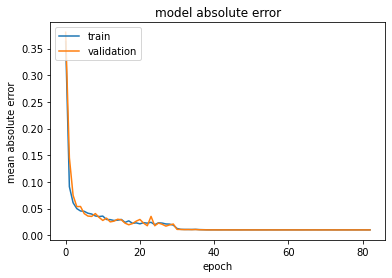

In [192]:
plt.plot(trained.history.history['mae'])
plt.plot(trained.history.history['val_mae'])
plt.title('model absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

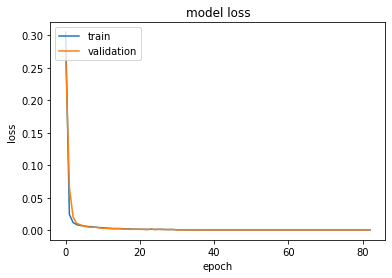

In [193]:
plt.plot(trained.history.history['loss'])
plt.plot(trained.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Validate 

In [194]:
val = data.loc[val_ids]
seqs = list(val.full_sequence)
res = adjust_prediction(pred.predict(seqs))
res['true'] = val['full_crick'].values
res['mse_f1']  = res.apply(lambda x: mse_f1_depend(x['true'], x['prediction']), axis=1)
correct = res[res['mse_f1'].notnull()]
len(correct) / len(res)

/tmp/ipykernel_25345/122919947.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val = data.loc[val_ids]


Encoded 1/450 sequences
Encoded 2/450 sequences
Encoded 3/450 sequences
Encoded 4/450 sequences
Encoded 5/450 sequences
Encoded 6/450 sequences
Encoded 7/450 sequences
Encoded 8/450 sequences
Encoded 9/450 sequences
Encoded 10/450 sequences
Encoded 11/450 sequences
Encoded 12/450 sequences
Encoded 13/450 sequences
Encoded 14/450 sequences
Encoded 15/450 sequences
Encoded 16/450 sequences
Encoded 17/450 sequences
Encoded 18/450 sequences
Encoded 19/450 sequences
Encoded 20/450 sequences
Encoded 21/450 sequences
Encoded 22/450 sequences
Encoded 23/450 sequences
Encoded 24/450 sequences
Encoded 25/450 sequences
Encoded 26/450 sequences
Encoded 27/450 sequences
Encoded 28/450 sequences
Encoded 29/450 sequences
Encoded 30/450 sequences
Encoded 31/450 sequences
Encoded 32/450 sequences
Encoded 33/450 sequences
Encoded 34/450 sequences
Encoded 35/450 sequences
Encoded 36/450 sequences
Encoded 37/450 sequences
Encoded 38/450 sequences
Encoded 39/450 sequences
Encoded 40/450 sequences
Encoded 4

1/1 [==============================] - 2s 2s/step


/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


0.9866071428571429

In [198]:
correct.iloc[0]['true']

array([10000.        , 10000.        , 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        ,    13.77787499,
         119.53491558,  -135.25185714,   -30.38129553,    72.71899207,
         172.1019244 ,   -85.62169671,    18.13405702,   114.21789005,
        -146.68963686,   -45.85923231, 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        ,    30.49353108,
         134.4049889 ,  -125.13812535,   -23.40045874,    81.46493069,
        -178.66560433,   -76.81948258,    25.00784274,   129.86794101,
        -132.8219043 ,   -27.1710893 , 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        , 10000.        ,
       10000.        , 10000.        , 10000.        ])

In [201]:
correct.iloc[0]['prediction']

array([1000, 1000, 1000, 1000, 1000, 1000, 1000,   20,  123, -131,  -28,
         73,  178,  -79,   21,  122, -133,  -33, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000,   22,  125, -134,  -32,   67,  168,  -92,    7,  107,
       -151,  -53, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

In [205]:
val = data.loc[val_ids]
seqs = list(val.full_sequence)
res = adjust_prediction(pred.predict(seqs))
res['true'] = val['full_crick'].values
res['mse_f1']  = res.apply(lambda x: mse_f1_depend(x['true'], x['prediction']), axis=1)
correct = res[res['mse_f1'].notnull()]
len(correct) / len(res)

/tmp/ipykernel_25345/122919947.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val = data.loc[val_ids]


Encoded 1/450 sequences
Encoded 2/450 sequences
Encoded 3/450 sequences
Encoded 4/450 sequences
Encoded 5/450 sequences
Encoded 6/450 sequences
Encoded 7/450 sequences
Encoded 8/450 sequences
Encoded 9/450 sequences
Encoded 10/450 sequences
Encoded 11/450 sequences
Encoded 12/450 sequences
Encoded 13/450 sequences
Encoded 14/450 sequences
Encoded 15/450 sequences
Encoded 16/450 sequences
Encoded 17/450 sequences
Encoded 18/450 sequences
Encoded 19/450 sequences
Encoded 20/450 sequences
Encoded 21/450 sequences
Encoded 22/450 sequences
Encoded 23/450 sequences
Encoded 24/450 sequences
Encoded 25/450 sequences
Encoded 26/450 sequences
Encoded 27/450 sequences
Encoded 28/450 sequences
Encoded 29/450 sequences
Encoded 30/450 sequences
Encoded 31/450 sequences
Encoded 32/450 sequences
Encoded 33/450 sequences
Encoded 34/450 sequences
Encoded 35/450 sequences
Encoded 36/450 sequences
Encoded 37/450 sequences
Encoded 38/450 sequences
Encoded 39/450 sequences
Encoded 40/450 sequences
Encoded 4

1/1 [==============================] - 1s 1s/step


/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


0.9866071428571429

Text(0.5, 1.0, 'Predictions for validation set')

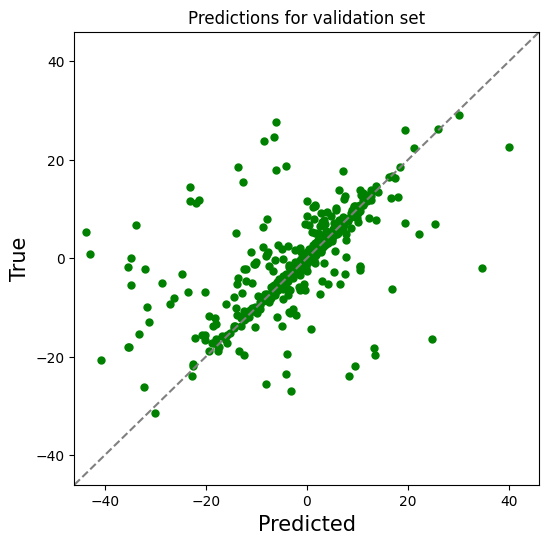

In [208]:
tr, pr = get_rot_tr_pred(correct)
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)
ax.scatter(pr, tr, color='green', s=25)
ax.set_ylim(-46, 46)
ax.set_xlim(-46, 46)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')
ax.set_xlabel('Predicted', size=15)
ax.set_ylabel('True', size=15)
ax.set_title('Predictions for validation set')

In [187]:
get_pr_tr_rmse(tr, pr)

17.238564536684876

In [56]:
val.iloc[0]['full_crick']

array([10000, 10000, 10000, 10000, 10000, 10000,    13,    66,   -61,
          -9,    41,    92,   -37,    15,    66,   -61,   -10, 10000,
       10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
       10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
       10000,    22,    73,   -55,    -5,    45,    94,   -36,    14,
          64,   -66,   -16, 10000, 10000, 10000, 10000, 10000, 10000,
       10000, 10000, 10000])

In [54]:
val.iloc[0]['full_crick']

array([10000, 10000, 10000, 10000, 10000, 10000,    13,    66,   -61,
          -9,    41,    92,   -37,    15,    66,   -61,   -10, 10000,
       10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
       10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
       10000,    22,    73,   -55,    -5,    45,    94,   -36,    14,
          64,   -66,   -16, 10000, 10000, 10000, 10000, 10000, 10000,
       10000, 10000, 10000])

In [38]:
val = data.loc[val_ids]
seqs = list(val.full_sequence)
res = pred.predict(seqs)
res['true'] = val['full_crick'].values
res['mse_f1']  = res.apply(lambda x: mse_f1_depend(x['true'], x['prediction']), axis=1)
correct = res[res['mse_f1'].notnull()]
len(correct) / len(res)

/tmp/ipykernel_27510/2137973637.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val = data.loc[val_ids]


Encoded 1/448 sequences
Encoded 2/448 sequences
Encoded 3/448 sequences
Encoded 4/448 sequences
Encoded 5/448 sequences
Encoded 6/448 sequences
Encoded 7/448 sequences
Encoded 8/448 sequences
Encoded 9/448 sequences
Encoded 10/448 sequences
Encoded 11/448 sequences
Encoded 12/448 sequences
Encoded 13/448 sequences
Encoded 14/448 sequences
Encoded 15/448 sequences
Encoded 16/448 sequences
Encoded 17/448 sequences
Encoded 18/448 sequences
Encoded 19/448 sequences
Encoded 20/448 sequences
Encoded 21/448 sequences
Encoded 22/448 sequences
Encoded 23/448 sequences
Encoded 24/448 sequences
Encoded 25/448 sequences
Encoded 26/448 sequences
Encoded 27/448 sequences
Encoded 28/448 sequences
Encoded 29/448 sequences
Encoded 30/448 sequences
Encoded 31/448 sequences
Encoded 32/448 sequences
Encoded 33/448 sequences
Encoded 34/448 sequences
Encoded 35/448 sequences
Encoded 36/448 sequences
Encoded 37/448 sequences
Encoded 38/448 sequences
Encoded 39/448 sequences
Encoded 40/448 sequences
Encoded 4

1/1 [==============================] - 2s 2s/step


/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/home/users/awinski/HAMPred/hamp_pred/src/input_prep/encode.py:184: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


0.9575892857142857

In [116]:
tr, pr = get_tr_pred(correct)

Text(0.5, 1.0, 'Predictions for validation set')

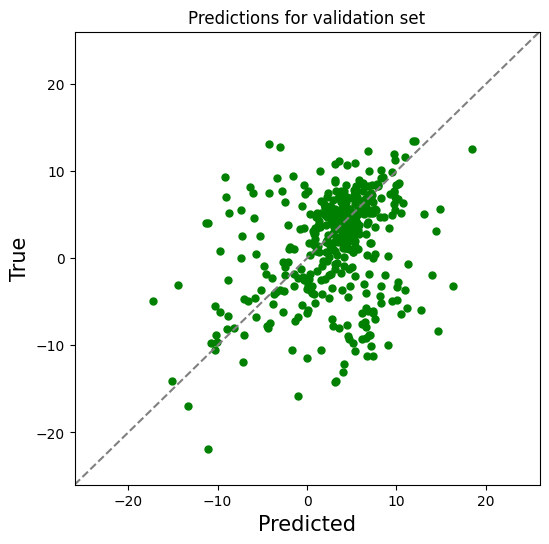

In [61]:
res.iloc[:1].apply(lambda x: mse_f1_depend(x['true'], x['prediction']), axis=1)

0    8.45
dtype: float64

In [47]:
print([x[0] for x in res.iloc[0]['prediction']])

[1000, 1000, 1000, 1000, 1000, 1000, 14, 64, -63, -12, 38, 87, -39, 12, 63, -63, -17, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 20, 75, -51, 1000, 44, 1000, -36, 12, 62, -66, -13, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [118]:
res = pred.predict(['STITRPIIELSNTADKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSLKVAME'])


Encoded 1/3 sequences
Encoded 2/3 sequences
Encoded 3/3 sequences
1/1 [==============================] - 1s 1s/step


In [122]:
get_segments(res.iloc[0]['prediction'])

([[array([14]),
   array([116]),
   array([-141]),
   array([-44]),
   array([63]),
   array([164]),
   array([-96]),
   array([8]),
   array([113]),
   array([-145]),
   array([-48]),
   array([1000]),
   array([1000]),
   array([1000]),
   array([1000]),
   array([1000]),
   array([1000])],
  [array([26]),
   array([130]),
   array([-127]),
   array([-28]),
   array([73]),
   array([171]),
   array([-85]),
   array([20]),
   array([123]),
   array([-132]),
   array([-33]),
   array([1000]),
   array([1000]),
   array([1000]),
   array([1000]),
   array([1000]),
   array([1000])]],
 [22, 50])

In [125]:
'STITRPIIELSNTADKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSLKVAME'[5:18]

'PIIELSNTADKIA'

In [127]:
print(pred.predict(['STITRPIIELSNTADKIAEGNLEAEVPHQNRADEIGILAKSIERLRRSLKVAME']).iloc[0]['prediction'])

Encoded 1/3 sequences
Encoded 2/3 sequences
Encoded 3/3 sequences
1/1 [==============================] - 1s 1s/step
[[1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [  14]
 [ 116]
 [-141]
 [ -44]
 [  63]
 [ 164]
 [ -96]
 [   8]
 [ 113]
 [-145]
 [ -48]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [  26]
 [ 130]
 [-127]
 [ -28]
 [  73]
 [ 171]
 [ -85]
 [  20]
 [ 123]
 [-132]
 [ -33]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]
 [1000]]


In [22]:
res.iloc[0]['sequence'][11:22]

'NTADKIAEGNL'

In [21]:
res.iloc[0]['sequence'][38:49]

'AKSIERLRRSL'

In [20]:
len(res.iloc[0]['sequence'])

54

Encoded 1/1 sequences
Encoded 1/1 sequences
1/1 [==============================] - 1s 1s/step
Encoded 1/206 sequences
Encoded 2/206 sequences
Encoded 3/206 sequences
Encoded 4/206 sequences
Encoded 5/206 sequences
Encoded 6/206 sequences
Encoded 7/206 sequences
Encoded 8/206 sequences
Encoded 9/206 sequences
Encoded 10/206 sequences
Encoded 11/206 sequences
Encoded 12/206 sequences
Encoded 13/206 sequences
Encoded 14/206 sequences
Encoded 15/206 sequences
Encoded 16/206 sequences
Encoded 17/206 sequences
Encoded 18/206 sequences
Encoded 19/206 sequences
Encoded 20/206 sequences
Encoded 21/206 sequences
Encoded 22/206 sequences
Encoded 23/206 sequences
Encoded 24/206 sequences
Encoded 25/206 sequences
Encoded 26/206 sequences
Encoded 27/206 sequences
Encoded 28/206 sequences
Encoded 29/206 sequences
Encoded 30/206 sequences
Encoded 31/206 sequences
Encoded 32/206 sequences
Encoded 33/206 sequences
Encoded 34/206 sequences
Encoded 35/206 sequences
Encoded 36/206 sequences
Encoded 37/206 

1/1 [==============================] - 1s 1s/step


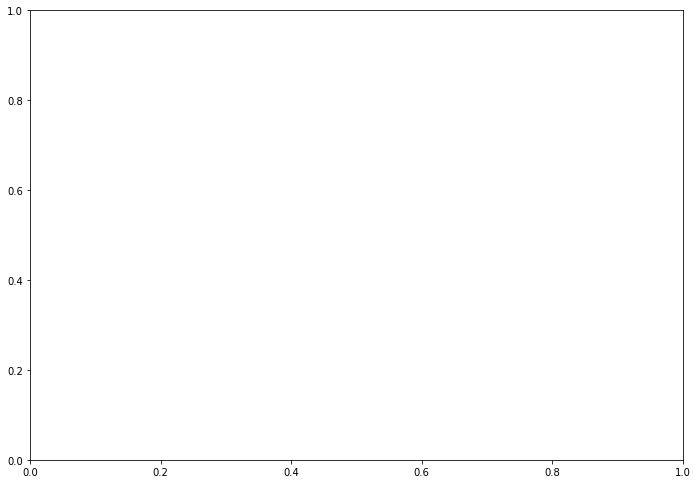

In [71]:
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                      parallel=True)
conf = PredictionConfig(None, operator)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
mod = Predictor('hamp_rot', config=conf)
mm, labels = mod.process_data(['NTADKIAEGNLAKSIERLRRSL'], kind='importance_describer', out_kind='heatmap')


<AxesSubplot:>

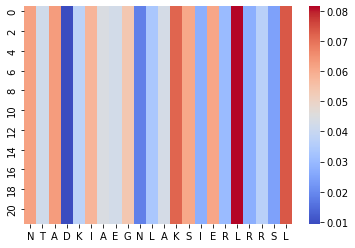

In [33]:
sns.heatmap(mm, xticklabels=labels,  cmap='coolwarm')

In [73]:
mod.predict(['NTADKIAEGNLAKSIERLRRSL']).iloc[0]['prediction']

Encoded 1/1 sequences
Encoded 1/1 sequences
1/1 [==============================] - 1s 1s/step


array([[ -3],
       [ -7],
       [ -9],
       [ -9],
       [-12],
       [-13],
       [-12],
       [ -9],
       [ -7],
       [ -8],
       [ -9],
       [ -3],
       [ -7],
       [ -9],
       [ -9],
       [-12],
       [-13],
       [-12],
       [ -9],
       [ -7],
       [ -8],
       [ -9]])